In [1]:
from sackmann import get_data

In [2]:
# Use this to clone the data if you need it
!git clone https://github.com/JeffSackmann/tennis_atp.git

df = get_data('./tennis_atp/')

fatal: destination path 'tennis_atp' already exists and is not an empty directory.


In [3]:
df.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,loser_rank_points,round_number,year,pts_won_serve_winner,pts_won_serve_loser,pts_played_serve_winner,pts_played_serve_loser,spw_winner,spw_loser,spw_margin
0,1968-580,Australian Chps.,Grass,64,G,1968-01-19,1,110023,NaN,NaN,...,NaN,2,1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1968-580,Australian Chps.,Grass,64,G,1968-01-19,2,109803,NaN,NaN,...,NaN,2,1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1968-580,Australian Chps.,Grass,64,G,1968-01-19,3,100257,NaN,NaN,...,NaN,2,1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1968-580,Australian Chps.,Grass,64,G,1968-01-19,4,100105,5.0,NaN,...,NaN,2,1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1968-580,Australian Chps.,Grass,64,G,1968-01-19,5,109966,NaN,NaN,...,NaN,2,1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
rel_df = df[df['tourney_date'].dt.year >= 1960]

In [5]:
rel_df.shape

(158394, 58)

In [6]:
# We're going to fit a hierarchical model to rate tennis players.

In [7]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

encoder.fit(rel_df['winner_name'].values.tolist() + rel_df['loser_name'].values.tolist())

names = encoder.classes_
winner_ids = encoder.transform(rel_df['winner_name'])
loser_ids = encoder.transform(rel_df['loser_name'])

In [8]:
from jax_advi.advi import optimize_advi_mean_field
from jax_advi.constraints import constrain_positive

theta_shapes = {
    'player_skills': (len(names)),
    'skill_prior_sd': ()
}

theta_constraints = {
    'skill_prior_sd': constrain_positive
}

In [9]:
len(names)

4763

In [10]:
from jax.scipy.stats import norm
from jax import jit
from jax.nn import log_sigmoid
import jax.numpy as jnp

@jit
def log_prior_fun(theta):
    
    # Prior
    skill_prior = jnp.sum(norm.logpdf(theta['player_skills'], 0., theta['skill_prior_sd']))
    
    # hyperpriors
    hyper_sd = norm.logpdf(theta['skill_prior_sd'])
    
    return skill_prior + hyper_sd

def log_lik_fun(theta, winner_ids, loser_ids):
    
    logit_probs = theta['player_skills'][winner_ids] - theta['player_skills'][loser_ids]
    
    return jnp.sum(log_sigmoid(logit_probs))

In [11]:
from functools import partial

curried_lik = jit(partial(log_lik_fun, winner_ids=winner_ids, loser_ids=loser_ids))

In [12]:
result = optimize_advi_mean_field(theta_shapes, log_prior_fun, curried_lik, 
                                  constrain_fun_dict=theta_constraints, verbose=True, M=25)

160192.84 41637.45
151053.33 3800.0847
150716.67 3660.9846
149508.73 3109.3862
147309.02 15814.718
146519.44 4730.473
142771.6 9055.841
130717.61 9677.662
117473.35 825.9168
114491.22 1212.0085
112448.11 1305.3455
107510.91 640.6632
106780.76 821.0412
105487.836 329.2855
104906.734 246.87888
104449.86 243.95021
103870.32 405.00192
105215.19 3475.1328
103817.18 604.64886
103720.52 212.69531
103692.79 163.68344
103628.45 166.92824
103528.89 185.82883
103387.44 188.86836
103236.17 171.15524
103206.945 230.39278
103074.44 61.301617
103049.74 67.68357
103023.83 129.71887
104193.02 5822.529
103022.59 69.976814
103010.7 57.63304
102985.016 172.71774
102972.14 132.87526
102959.016 51.29385
102950.875 52.472935
102940.5 55.40928
102912.086 63.338257
102885.35 57.660275
102900.29 129.14653
102874.99 62.715515
102861.75 25.965292
102855.69 116.18591
102869.016 465.6508
102853.07 63.37019
102851.17 28.533253
102849.4 24.409075
102848.234 24.999077
102850.086 189.85645
102846.39 87.00065
102842.91 

In [13]:
import pandas as pd

mean_skills_advi = pd.Series(result['free_means']['player_skills'], index=names).sort_values(ascending=False)

In [14]:
print(mean_skills_advi.head(20).round(2).to_markdown())

|                       |    0 |
|:----------------------|-----:|
| Novak Djokovic        | 3.57 |
| Rafael Nadal          | 3.44 |
| Roger Federer         | 3.34 |
| Ivan Lendl            | 3.23 |
| Bjorn Borg            | 3.2  |
| John McEnroe          | 3.18 |
| Jimmy Connors         | 3.15 |
| Rod Laver             | 3.04 |
| Andy Murray           | 2.95 |
| Pete Sampras          | 2.9  |
| Boris Becker          | 2.79 |
| Andre Agassi          | 2.75 |
| Stefan Edberg         | 2.74 |
| Andy Roddick          | 2.73 |
| Juan Martin del Potro | 2.69 |
| Arthur Ashe           | 2.65 |
| Ken Rosewall          | 2.62 |
| Guillermo Vilas       | 2.59 |
| John Newcombe         | 2.55 |
| Mats Wilander         | 2.47 |


In [15]:
# Compare with stan
from stan_utils import load_stan_model_cached

stan_model = load_stan_model_cached('stan_tennis.stan')

In [16]:
stan_data = {
    'N': winner_ids.shape[0],
    'P': len(names),
    'winner_ids': winner_ids + 1,
    'loser_ids': loser_ids + 1
}

In [17]:
import numpy as np

# Uncomment if you want to fit the Stan model. It takes a while though!
#stan_fit = stan_model.sampling(data=stan_data)
stan_fit = np.load('./stan_samples.npz')

In [18]:
player_skills = stan_fit['player_skills']

In [19]:
mean_skills = player_skills.mean(axis=0)
advi_sds = result['free_sds']['player_skills']

In [20]:
mean_skills = pd.Series(mean_skills, index=names)

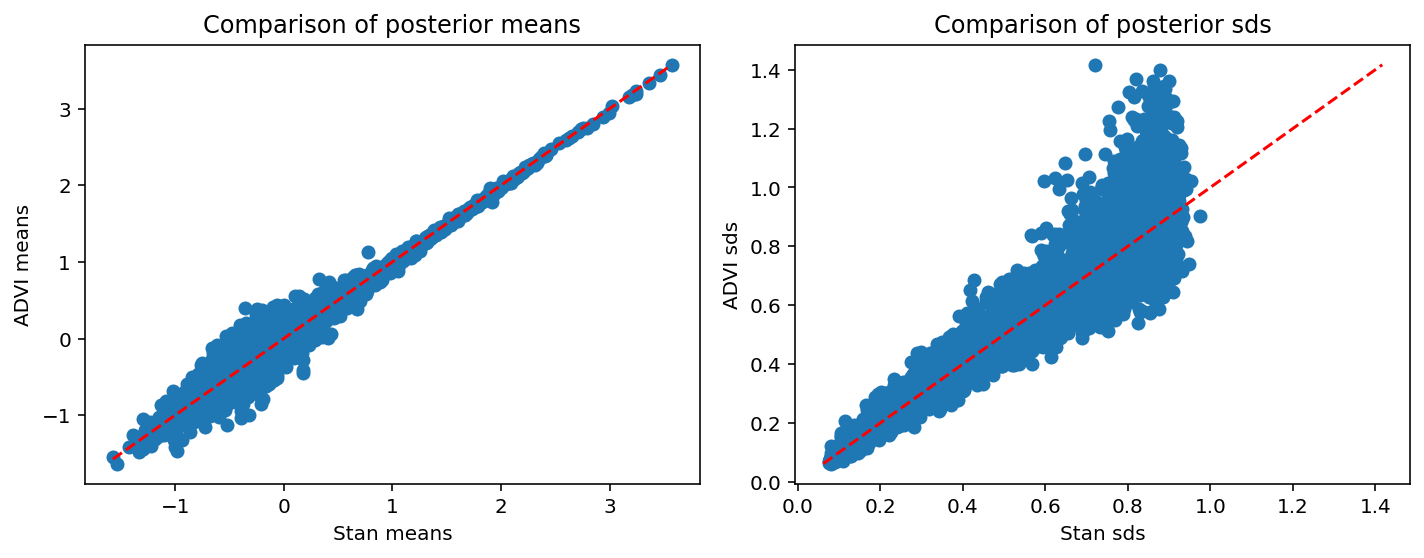

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots(1, 2)

ax[0].scatter(mean_skills, mean_skills_advi.loc[mean_skills.index])
ax[0].plot([mean_skills.min(), mean_skills.max()], [mean_skills.min(), mean_skills.max()], color='r', linestyle='--')

ax[1].scatter(player_skills.std(axis=0), advi_sds)
ax[1].plot([advi_sds.min(), advi_sds.max()], [advi_sds.min(), advi_sds.max()], linestyle='--', color='r')

ax[0].set_title('Comparison of posterior means')
ax[1].set_title('Comparison of posterior sds')

ax[0].set_xlabel('Stan means')
ax[0].set_ylabel('ADVI means')

ax[1].set_xlabel('Stan sds')
ax[1].set_ylabel('ADVI sds')

f.set_size_inches(10, 4)
f.tight_layout()

plt.savefig('tennis_comparison.png', dpi=300)

In [22]:
import numpy as np

# Save the Stan samples.
#np.savez('stan_samples', **stan_fit.extract())

In [23]:
# Try Stan's ADVI
vb_result_stan = stan_model.vb(data=stan_data, )

In [24]:
vb_result_stan.keys()

odict_keys(['args', 'inits', 'sampler_params', 'sampler_param_names', 'mean_pars', 'mean_par_names'])

In [25]:
stan_advi_res = [y for x, y in zip(vb_result_stan['mean_par_names'], vb_result_stan['mean_pars']) 
 if 'player_skills[' in x]

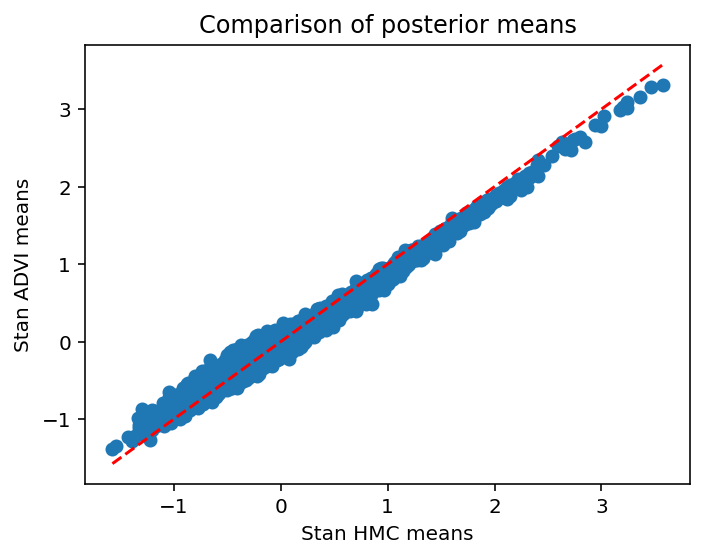

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(mean_skills, stan_advi_res)
plt.plot([mean_skills.min(), mean_skills.max()], [mean_skills.min(), mean_skills.max()], color='r', linestyle='--')

plt.title('Comparison of posterior means')

plt.xlabel('Stan HMC means')
plt.ylabel('Stan ADVI means')

plt.gcf().set_size_inches(5, 4)
plt.gcf().tight_layout()

plt.savefig('tennis_comparison_stan_advi.png', dpi=300)



In [28]:
# LRVB -- experimental
# Warning, this can take a few minutes on a GPU (4.5 on my GTX 2070).
from jax_advi.lrvb import compute_lrvb_covariance, get_posterior_draws_lrvb

lrvb_free_sds, lrvb_cov_mat = compute_lrvb_covariance(
    result['final_var_params_flat'], result['objective_fun'], result['shape_summary'], batch_size=8)

100%|██████████| 596/596 [04:14<00:00,  2.34it/s]


In [41]:
# Make draws from the LRVB objective
lrvb_draws = get_posterior_draws_lrvb(np.split(result['final_var_params_flat'], 2)[0],
                                     lrvb_cov_mat, result['shape_summary'], theta_constraints, n_draws=4000)

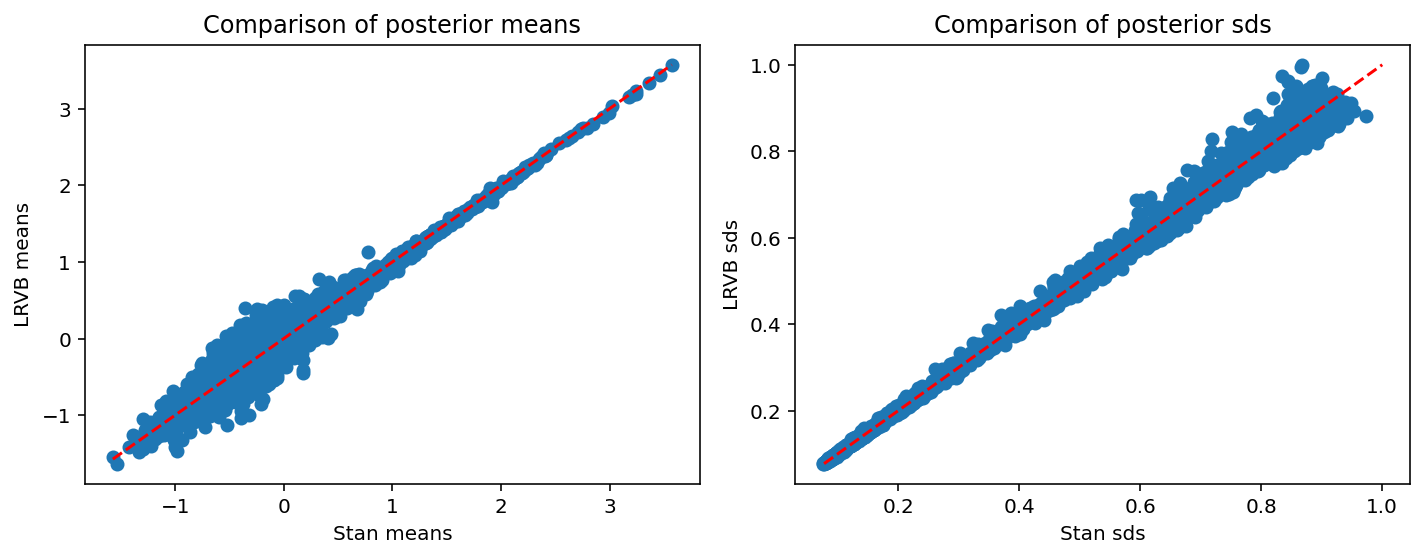

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots(1, 2)

advi_sds = lrvb_draws['player_skills'].std(axis=0)

ax[0].scatter(mean_skills, mean_skills_advi.loc[mean_skills.index])
ax[0].plot([mean_skills.min(), mean_skills.max()], [mean_skills.min(), mean_skills.max()], color='r', linestyle='--')

ax[1].scatter(player_skills.std(axis=0), advi_sds)
ax[1].plot([advi_sds.min(), advi_sds.max()], [advi_sds.min(), advi_sds.max()], linestyle='--', color='r')

ax[0].set_title('Comparison of posterior means')
ax[1].set_title('Comparison of posterior sds')

ax[0].set_xlabel('Stan means')
ax[0].set_ylabel('LRVB means')

ax[1].set_xlabel('Stan sds')
ax[1].set_ylabel('LRVB sds')

f.set_size_inches(10, 4)
f.tight_layout()

plt.savefig('tennis_comparison_lrvb.png', dpi=300)